                  y    y_adjusted             x
count  1.048576e+07  1.048576e+07  1.048576e+07
mean   4.424662e+04  2.250729e+03  5.242880e+07
std    6.811289e+05  3.406638e+04  3.026978e+07
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    0.000000e+00  0.000000e+00  2.621440e+07
50%    0.000000e+00  0.000000e+00  5.242880e+07
75%    0.000000e+00  0.000000e+00  7.864319e+07
max    1.738433e+07  8.692166e+05  1.048576e+08


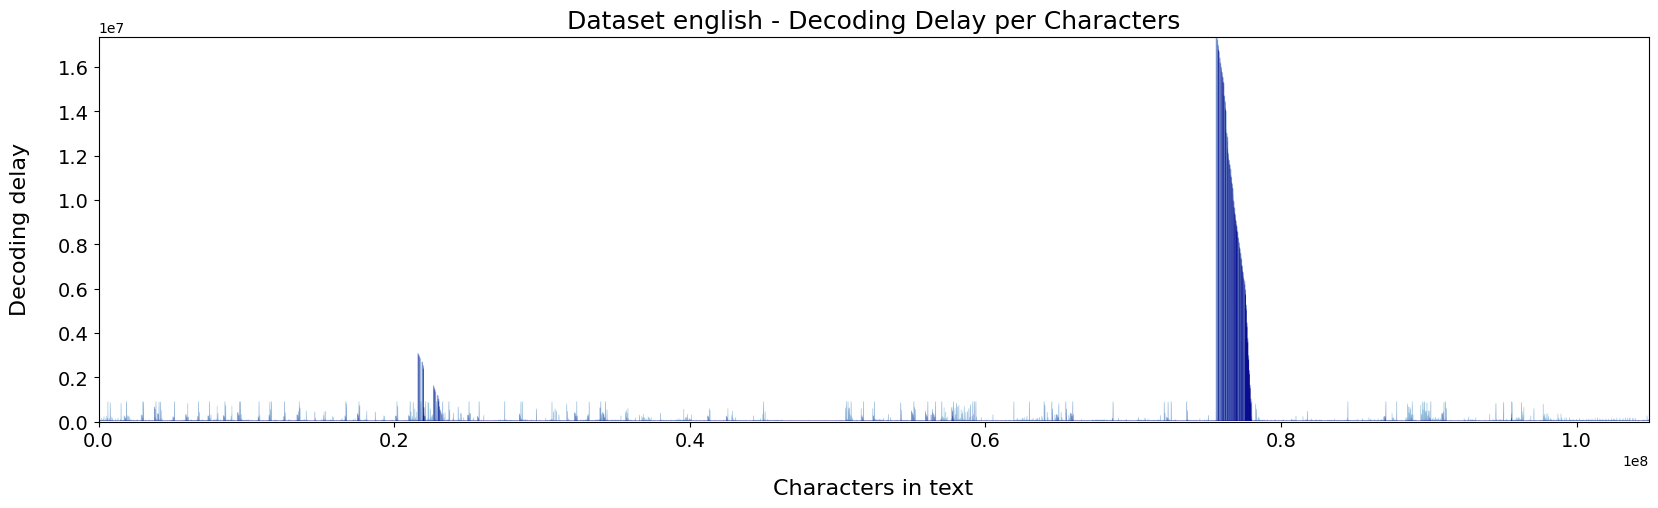

In [2]:
import polars as pl
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt
import numpy as np

file = 'english'
file2 = 'english'

df1 = pl.read_csv(f'delays_txt/{file}_delays.txt', has_header=False, schema_overrides={"column_1": pl.Float64})
df1 = df1.rename({'column_1': 'y'})

y_min1 = df1['y'].min()
y_max1 = df1['y'].max()

df1 = df1.with_columns([
    pl.Series(name='x', values=range(len(df1)))
])

step = 10
df_reduced1 = df1[::step]

threshold1 = df_reduced1['y'].mean()

df_reduced1 = df_reduced1.with_columns([
    pl.when(df_reduced1['y'] > threshold1).then(df_reduced1['y'] / 20).otherwise(df_reduced1['y']).alias('y_adjusted')
])

df2 = pl.read_csv(f'delays_txt/{file2}_delays.txt', has_header=False, schema_overrides={"column_1": pl.Float64})
df2 = df2.rename({'column_1': 'y'})

y_min2 = df2['y'].min()
y_max2 = df2['y'].max()

df2 = df2.with_columns([
    pl.when(df2['y'] > threshold1).then(df2['y'] / 20).otherwise(df2['y']).alias('y_adjusted')
])

df2 = df2.with_columns([
    pl.Series(name='x', values=range(len(df2)))
])

df_reduced2 = df2[::step]

df_pandas2 = df_reduced2.to_pandas()

print(df_pandas2.describe())

canvas = ds.Canvas(plot_width=2000, plot_height=1000)
agg = canvas.line(df_pandas2, 'x', 'y_adjusted', ds.count())

img = tf.shade(agg)
img = tf.set_background(img, "white").to_pil()

plt.figure(figsize=(20, 5))
plt.imshow(img, aspect='auto', extent=(0, len(df2) - 1, y_min1, y_max1), origin='upper')
plt.ylim(y_min1, y_max1)

plt.xlabel('Characters in text', fontsize=16, labelpad=20) 
plt.ylabel('Decoding delay', fontsize=16, labelpad=20) 
plt.title(f'Dataset {file} - Decoding Delay per Characters', fontsize=18)

plt.xticks(fontsize=16)  
plt.yticks(fontsize=16)  

plt.tick_params(axis='both', which='major', labelsize=14)

plt.savefig(f'delays_png/{file2}-delay.png', bbox_inches='tight', pad_inches=0.1)
plt.show()